In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
import joblib
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('cln_hotel_bookings.csv')
df = df.drop('Unnamed: 0', axis = 1)

In [8]:
df.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,1.0,-0.447552,-1.0,-0.166667,0.0,-1.0,-0.5,-0.5,-1.0,0.0,...,0.0,0.0,-0.061224,0.0,0.0,0.0,-0.363636,0.0,0.0,0
1,1.0,-0.405594,-1.0,-0.166667,0.0,-1.0,-0.5,-0.5,-1.0,0.0,...,0.0,0.0,2.006803,0.0,0.0,0.0,-0.363636,0.0,0.0,0
2,1.0,-0.398601,-1.0,-0.166667,0.0,-1.0,-0.5,0.0,0.0,0.0,...,0.0,0.0,1.571429,0.0,0.0,0.0,0.054545,0.0,1.0,0
3,1.0,-0.398601,-1.0,-0.166667,0.0,-1.0,-0.5,0.0,0.0,0.0,...,0.0,0.0,1.571429,0.0,0.0,0.0,0.054545,0.0,1.0,0
4,1.0,-0.496503,-1.0,-0.166667,0.0,-1.0,-0.5,0.0,0.0,0.0,...,0.0,0.0,-0.061224,0.0,0.0,0.0,0.218182,0.0,0.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116957 entries, 0 to 116956
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           116957 non-null  float64
 1   lead_time                       116957 non-null  float64
 2   arrival_date_year               116957 non-null  float64
 3   arrival_date_month              116957 non-null  float64
 4   arrival_date_week_number        116957 non-null  float64
 5   arrival_date_day_of_month       116957 non-null  float64
 6   stays_in_weekend_nights         116957 non-null  float64
 7   stays_in_week_nights            116957 non-null  float64
 8   adults                          116957 non-null  float64
 9   children                        116957 non-null  float64
 10  babies                          116957 non-null  float64
 11  meal                            116957 non-null  float64
 12  country         

## Feature Selection

In [10]:
x_feat = df.drop('is_canceled', axis = 1)
y_feat = df['is_canceled']

[0.01424794 0.1030706  0.02741434 0.0321696  0.04642653 0.04863855
 0.03046896 0.04127936 0.01725267 0.0087791  0.00135542 0.01655784
 0.12009604 0.04225087 0.0179057  0.00457372 0.02209284 0.00177929
 0.01596578 0.02787191 0.02046099 0.11957563 0.04013703 0.00453076
 0.00288909 0.02865621 0.05830792 0.02459954 0.06064579]


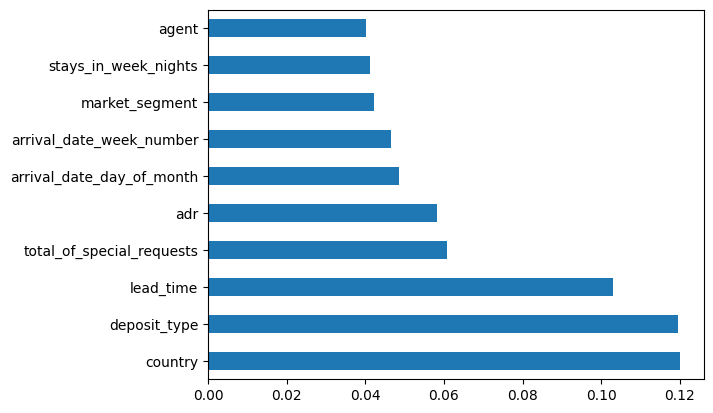

In [11]:
# melakukan feature selection dengan menggunakan Feature Importance

model = ExtraTreesClassifier()
model.fit(x_feat, y_feat)

print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index = x_feat.columns)
feat_importances.nlargest(10).plot.barh()
plt.show()

In [12]:
# Melakukan pemilihan feature berdasarkan feature importance di atas
# walaupun feature 'agent' masuk dalam 10 feature importance di atas
# tetapi saya tidak memasukan feature tsb , karena tidak relevan
# karena fitur tersebut memiliki value ID dari agent dalam melakukan booking (yg sama dengan fitur 'company')
# saya berasumsi ketika input pada dashboard semua booking dilakukan secara independen

X = df[['country', 
        'deposit_type', 
        'lead_time', 
        'total_of_special_requests', 
        'adr', 
        'market_segment', 
        'arrival_date_day_of_month', 
        'arrival_date_week_number', 
        'stays_in_week_nights'
       ]]

y = df['is_canceled']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 101)

## Modeling Dengan Langsung Melakukan Hyper Parameter Tuning

### Logistic Regression

In [14]:
lr_params = {
            'C': [0.1, 0.5, 0.9, 1, 2, 5],
            'penalty':['l1','l2'],
            'random_state':[24,32,56,65]
            }

params = {
        'estimator': LogisticRegression(),
        'param_distributions': lr_params,
        'cv': 5,
        'n_iter': 15,
        'n_jobs': -1,
        'scoring': 'roc_auc',
        }

lr_cv = RandomizedSearchCV(**params)

In [15]:
lr_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=15, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 0.9, 1, 2, 5],
                                        'penalty': ['l1', 'l2'],
                                        'random_state': [24, 32, 56, 65]},
                   scoring='roc_auc')

In [16]:
lr_cv.best_params_
# lr_best_param = {'C': 5, 'penalty': 'l1', 'random_state': 24} 

{'random_state': 24, 'penalty': 'l2', 'C': 2}

In [17]:
lr_model = LogisticRegression(**lr_cv.best_params_).fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
proba_lr = lr_model.predict_proba(X_test)

In [18]:
accuracy_score(y_test, y_pred_lr)

0.7621694026447788

In [19]:
cross_val_score(lr_model, X_test, y_test, cv = 10).mean()

np.float64(0.7608584278965994)

In [20]:
print(confusion_matrix(y_test, y_pred_lr))
print('\n')
print(classification_report(y_test, y_pred_lr))

[[20185  1752]
 [ 6593  6558]]


              precision    recall  f1-score   support

           0       0.75      0.92      0.83     21937
           1       0.79      0.50      0.61     13151

    accuracy                           0.76     35088
   macro avg       0.77      0.71      0.72     35088
weighted avg       0.77      0.76      0.75     35088



In [21]:
def lr_curve():    
    fpr_lr, tpr_lr, thres_lr = roc_curve(y_test, proba_lr[:,1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)

    plt.subplot(151)
    plt.title('ROC AUC Logistic Regression')
    plt.plot(fpr_lr, tpr_lr, 'blue', label='AUC Logistic Regression = {}'.format(round(roc_auc_lr,4)))
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr_lr,tpr_lr, 0, facecolor='orange', alpha=1)
    plt.legend(loc = 'lower right')

### Random Forest Class.

In [22]:
rf_params = {
        'max_depth': [5, 10, 15, 20],
        'max_features': [2, 3, 5],
        'n_estimators': [100, 500, 1000],
        'min_samples_split': [5, 10, 15],
        }

params = {
        'estimator': RandomForestClassifier(),
        'param_distributions': rf_params,
        'cv': 5,
        'n_iter': 15,
        'n_jobs': -1,
        'scoring': 'roc_auc',
        }

rf_cv = RandomizedSearchCV(**params)

In [23]:
rf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'max_features': [2, 3, 5],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [100, 500, 1000]},
                   scoring='roc_auc')

In [24]:
rf_cv.best_params_
# rf_best_param = {
#                'max_depth': 20,
#                'max_features': 3,
#                'min_samples_split': 5,
#                'n_estimators': 100
#                }

{'n_estimators': 1000,
 'min_samples_split': 5,
 'max_features': 2,
 'max_depth': 20}

In [25]:
rf_model = RandomForestClassifier(**rf_cv.best_params_).fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
proba_rf = rf_model.predict_proba(X_test)

In [26]:
accuracy_score(y_test, y_pred_rf)

0.8541666666666666

In [27]:
cross_val_score(rf_model, X_test, y_test, cv = 10).mean()

np.float64(0.8427954115707678)

In [28]:
print(confusion_matrix(y_test, y_pred_rf))
print('\n')
print(classification_report(y_test, y_pred_rf))

[[20153  1784]
 [ 3333  9818]]


              precision    recall  f1-score   support

           0       0.86      0.92      0.89     21937
           1       0.85      0.75      0.79     13151

    accuracy                           0.85     35088
   macro avg       0.85      0.83      0.84     35088
weighted avg       0.85      0.85      0.85     35088



In [29]:
def rf_curve():    
    fpr_rf, tpr_rf, thres_rf = roc_curve(y_test, proba_rf[:,1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.subplot(152)
    plt.title('ROC AUC Random Forest')
    plt.plot(fpr_rf, tpr_rf, 'blue', label='AUC Rand. Forest = {}'.format(round(roc_auc_rf,4)))
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr_rf,tpr_rf, 0, facecolor='lightyellow', alpha=1)
    plt.legend(loc = 'lower right')

### Gradient Boosting

In [30]:
gb_parameters = {
                'n_estimators': [100, 500, 1000],
                'max_depth': [3, 5, 10],
                'min_samples_split': [2, 5, 10],
                }

gb_params = {
            'estimator': GradientBoostingClassifier(),
            'param_distributions': gb_parameters,
            'cv': 5,
            'n_iter': 15,
            'n_jobs': -1,
            'scoring': 'roc_auc',
            }

gb_cv = RandomizedSearchCV(**gb_params)

In [31]:
gb_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=15,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 500, 1000]},
                   scoring='roc_auc')

In [32]:
gb_cv.best_params_
# gb_best_param = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}

{'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 10}

In [33]:
gb_model = GradientBoostingClassifier(**gb_cv.best_params_).fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
proba_gb = gb_model.predict_proba(X_test)

In [34]:
accuracy_score(y_test, y_pred_gb)

0.8614911080711354

In [35]:
cross_val_score(gb_model, X_test, y_test, cv = 10).mean()

np.float64(0.8375800312147328)

In [36]:
print(confusion_matrix(y_test, y_pred_gb))
print('\n')
print(classification_report(y_test, y_pred_gb))

[[20056  1881]
 [ 2979 10172]]


              precision    recall  f1-score   support

           0       0.87      0.91      0.89     21937
           1       0.84      0.77      0.81     13151

    accuracy                           0.86     35088
   macro avg       0.86      0.84      0.85     35088
weighted avg       0.86      0.86      0.86     35088



In [37]:
def gb_curve():    
    fpr_gb, tpr_gb, thres_gb = roc_curve(y_test, proba_gb[:,1])
    roc_auc_gb = auc(fpr_gb, tpr_gb)

    plt.subplot(153)
    plt.title('ROC AUC Gradient Boosting')
    plt.plot(fpr_gb, tpr_gb, 'blue', label='AUC Gradient Boosting = {}'.format(round(roc_auc_gb,4)))
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr_gb,tpr_gb, 0, facecolor='lightblue', alpha=1)
    plt.legend(loc = 'lower right')

### KNN

In [38]:
knn_parameters = {'n_neighbors': range(1, 11), 
                  'leaf_size': range(30, 35)}

knn_params = {
            'estimator': KNeighborsClassifier(),
            'param_distributions': knn_parameters,
            'cv': 5,
            'n_iter': 15,
            'n_jobs': -1,
            'scoring': 'roc_auc',
            }

knn_cv = RandomizedSearchCV(**knn_params)

In [39]:
knn_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'leaf_size': range(30, 35),
                                        'n_neighbors': range(1, 11)},
                   scoring='roc_auc')

In [40]:
knn_cv.best_params_
# knn_best_param = {'n_neighbors': 10}

{'n_neighbors': 10, 'leaf_size': 31}

In [41]:
knn_model = KNeighborsClassifier(**knn_cv.best_params_).fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
proba_kn = knn_model.predict_proba(X_test)

In [42]:
accuracy_score(y_test, y_pred_knn)

0.8130699954400364

In [43]:
cross_val_score(knn_model, X_test, y_test, cv = 10).mean()

np.float64(0.7987060963614333)

In [44]:
print(confusion_matrix(y_test, y_pred_knn))
print('\n')
print(classification_report(y_test, y_pred_knn))

[[20123  1814]
 [ 4745  8406]]


              precision    recall  f1-score   support

           0       0.81      0.92      0.86     21937
           1       0.82      0.64      0.72     13151

    accuracy                           0.81     35088
   macro avg       0.82      0.78      0.79     35088
weighted avg       0.81      0.81      0.81     35088



In [45]:
def knn_curve():    
    fpr_kn, tpr_kn, thres_kn = roc_curve(y_test, proba_kn[:,1])
    roc_auc_kn = auc(fpr_kn, tpr_kn)

    plt.subplot(154)
    plt.title('ROC AUC KNN')
    plt.plot(fpr_kn, tpr_kn, 'blue', label='AUC KNN = {}'.format(round(roc_auc_kn,4)))
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr_kn,tpr_kn, 0, facecolor='azure', alpha=1)
    plt.legend(loc = 'lower right')

## XBG Classifier

In [46]:
xgb_parameters = {'n_estimators': [100, 500, 1000],  
                  'max_depth': [3, 5, 10]
                 }

xgb_params = {
            'estimator': XGBClassifier(),
            'param_distributions': xgb_parameters,
            'cv': 5,
            'n_iter': 15,
            'n_jobs': -1,
            'scoring': 'roc_auc',
            }

xgb_cv = RandomizedSearchCV(**xgb_params)

In [47]:
# xgb_cv.fit(X_train, y_train)

In [48]:
# xgb_cv.best_params_
xgb_cv.best_param = {'n_estimators': 500, 'max_depth': 10}

In [49]:
xgb_model = XGBClassifier(**xgb_cv.best_param).fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
proba_xgb = xgb_model.predict_proba(X_test)

In [50]:
accuracy_score(y_test, y_pred_xgb)

0.8556486548107615

In [51]:
cross_val_score(xgb_model, X_test, y_test, cv = 10).mean()

np.float64(0.8328204993642345)

In [52]:
print(confusion_matrix(y_test, y_pred_xgb))
print('\n')
print(classification_report(y_test, y_pred_xgb))

[[19818  2119]
 [ 2946 10205]]


              precision    recall  f1-score   support

           0       0.87      0.90      0.89     21937
           1       0.83      0.78      0.80     13151

    accuracy                           0.86     35088
   macro avg       0.85      0.84      0.84     35088
weighted avg       0.85      0.86      0.85     35088



In [53]:
def xgb_curve():    
    fpr_xgb, tpr_xgb, thres_xgb = roc_curve(y_test, proba_xgb[:,1])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

    plt.subplot(155)
    plt.title('ROC AUC XGB')
    plt.plot(fpr_xgb, tpr_xgb, 'blue', label='AUC XGB = {}'.format(round(roc_auc_xgb,4)))
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.fill_between(fpr_xgb,tpr_xgb, 0, facecolor='lightgreen', alpha=1)
    plt.legend(loc = 'lower right')
    plt.show()

### Model Score with train data

In [ ]:
scores = []
for model in [lr_model, rf_model, gb_model, knn_model, xgb_model]:
    scores.append(round(model.score(X_train, y_train)*100))

scores_df = pd.DataFrame({'MODEL': ['Logistic Reg', 
                                    'Random Forest', 
                                    'Gradient Boost', 
                                    'KNN model', 
                                    'XGB classifier'], 'SCORE': scores})
scores_df

,MODEL,SCORE
0,Logistic Reg,77
1,Random Forest,94
2,Gradient Boost,99
3,KNN model,84
4,XGB classifier,99


### Model Score with test data

In [55]:
scores = []
for model in [lr_model, rf_model, gb_model, knn_model, xgb_model]:
    scores.append(round(model.score(X_test, y_test)*100))

scores_df = pd.DataFrame({'MODEL': ['Logistic Reg', 
                                    'Random Forest', 
                                    'Gradient Boost', 
                                    'KNN model', 
                                    'XGB classifier'], 'SCORE': scores})
scores_df

,MODEL,SCORE
0,Logistic Reg,76
1,Random Forest,85
2,Gradient Boost,86
3,KNN model,81
4,XGB classifier,86


## ROC AUC dari Setiap Model

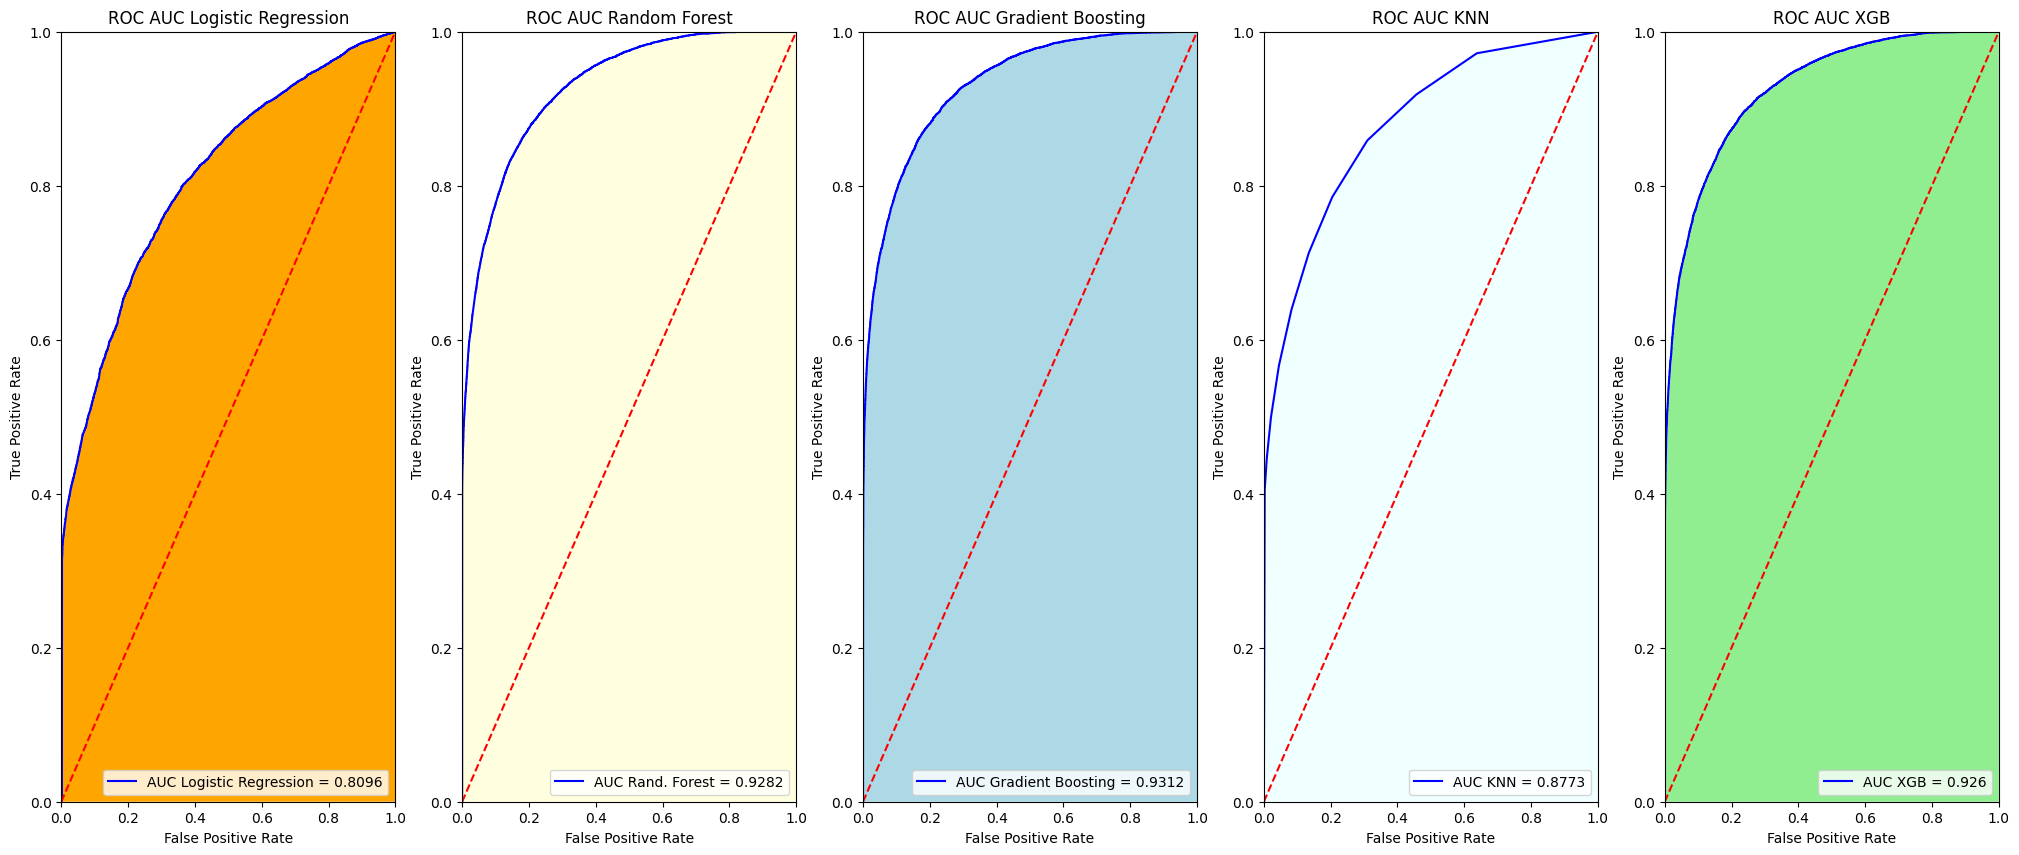

In [56]:
plt.figure(figsize = (25, 10))
lr_curve()
rf_curve()
gb_curve()
knn_curve()
xgb_curve()

#### Berdasarkan kedua tabel Score diatas , jika dilihat berdasarkan perolehan score dari setiap classifier dengan menggunakan data train. model dengan classifier Gradient Boost dan XGB memiliki score yang sama dimana hampir 100%, dengan score 99%.

#### Sedangkan jika melihat score dari setiap model dengan menggunakan data test, model dengan classifier Gradient Boost memiliki score yang paling tinggi.

#### Kemudian jika dilihat dari ROC Curve di atas, classifier Gradient Boost memiliki nilai AUC yang paling tinggi.

#### Karena berdasarkan EDA target label memiliki proporsi 60:40 , dapat juga menggunakan accuracy score untuk pemilihan model. dimana Gradient Boost dan XGB memiliki score accuracy yang sama (86%), tetapi pada AUC score Gradient Boost memiliki score tertinggi.

#### Berdasarkan hal tersebut saya memilih Gradient Boost Classifier sebagai best estimator. 

## Oversampling Data

In [57]:
# Dengan SMOTE

sm = SMOTE(random_state = 42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [58]:
# Dengan Random Oversampling

randov = RandomOverSampler(sampling_strategy = 'minority')
X_randov, y_randov = randov.fit_resample(X_train, y_train)

In [59]:
# X_train setelah oversampling dengan SMOTE

df_sm = pd.DataFrame(X_sm, columns = X_train.columns)
df_sm

,country,deposit_type,lead_time,total_of_special_requests,adr,market_segment,arrival_date_day_of_month,arrival_date_week_number,stays_in_week_nights
0,-0.658228,0.0,0.013986,1.0,0.989091,0.5,0.000000,-0.090909,0.5
1,0.683544,1.0,0.818182,0.0,0.636364,0.0,-0.066667,-0.090909,0.0
2,-0.341772,0.0,0.216783,0.0,0.563636,0.5,0.066667,-0.136364,-0.5
3,0.683544,0.0,0.342657,1.0,-0.172727,0.5,0.733333,0.000000,0.0
4,-0.481013,0.0,-0.279720,1.0,-0.490909,0.0,-0.333333,-0.772727,0.5
...,...,...,...,...,...,...,...,...,...
102137,-0.278481,0.0,0.103995,0.0,0.352150,0.5,0.485353,0.312673,0.0
102138,-0.004115,0.0,0.863314,1.0,0.643327,0.5,0.536801,-0.092682,-0.5
102139,-0.471696,0.0,0.882173,0.0,0.477286,0.5,0.007549,0.262433,1.0
102140,0.683544,1.0,1.664336,0.0,-0.600000,-0.5,-0.266667,-0.318182,0.0


In [60]:
# y_train setelah oversampling dengan SMOTE

y_sm = pd.DataFrame(y_sm)
y_sm['is_canceled'] = y_sm[0]

KeyError: 0

In [61]:
y_sm

,is_canceled
0,0
1,1
2,0
3,0
4,0
...,...
102137,1
102138,1
102139,1
102140,1


In [62]:
# X_train setelah oversampling dengan random ovsampling

df_randov = pd.DataFrame(X_randov, columns = X_train.columns)
df_randov

,country,deposit_type,lead_time,total_of_special_requests,adr,market_segment,arrival_date_day_of_month,arrival_date_week_number,stays_in_week_nights
0,-0.658228,0.0,0.013986,1.0,0.989091,0.5,0.000000,-0.090909,0.5
1,0.683544,1.0,0.818182,0.0,0.636364,0.0,-0.066667,-0.090909,0.0
2,-0.341772,0.0,0.216783,0.0,0.563636,0.5,0.066667,-0.136364,-0.5
3,0.683544,0.0,0.342657,1.0,-0.172727,0.5,0.733333,0.000000,0.0
4,-0.481013,0.0,-0.279720,1.0,-0.490909,0.0,-0.333333,-0.772727,0.5
...,...,...,...,...,...,...,...,...,...
102137,-0.658228,0.0,-0.048951,0.0,-0.382727,0.5,-0.266667,-0.909091,0.0
102138,-0.113924,0.0,1.398601,2.0,0.087455,0.5,-0.800000,0.000000,1.5
102139,-0.063291,0.0,-0.062937,0.0,1.467455,0.5,0.933333,0.363636,1.5
102140,-0.379747,0.0,1.230769,0.0,2.709091,0.5,0.333333,0.318182,0.5


In [63]:
# y_train setelah oversampling dengan random ovsampling

y_randov = pd.DataFrame(y_randov)
y_randov['is_canceled'] = y_randov[0]

KeyError: 0

In [64]:
y_randov

,is_canceled
0,0
1,1
2,0
3,0
4,0
...,...
102137,1
102138,1
102139,1
102140,1


In [65]:
# Buat model Gradient Boost dengan SMOTE

gb_model_sm = gb_model.fit(df_sm, y_sm)

In [66]:
# Buat model Gradient Boost dengan Random Ovsampling

gb_model_rand = gb_model.fit(df_randov, y_randov)

In [ ]:
# Predict dengan random ovsampling

y_pred_rand = gb_model_rand.predict(X_test)
proba_rand = gb_model_rand.predict_proba(X_test)

In [ ]:
# Predict dengan SMOTE

y_pred_gbsm = gb_model_sm.predict(X_test)
proba_gbsm = gb_model_sm.predict_proba(X_test)

In [ ]:
# Cross Validation score (SMOTE)

cross_val_score(gb_model_sm, X_test, y_test, cv = 10).mean()

In [ ]:
# Cross Validation score (Random ovsampling)

cross_val_score(gb_model_rand, X_test, y_test, cv = 10).mean()

In [ ]:
# Cross Validation score (Data Awal)

cross_val_score(gb_model, X_test, y_test, cv = 10).mean()

In [ ]:
# dengan menggunakan SMOTE

print(classification_report(y_test, y_pred_gbsm))
print(confusion_matrix(y_test, y_pred_gbsm))
confus_gbsm = confusion_matrix(y_test, y_pred_gbsm)
sns.heatmap(confus_gbsm, annot = True)

In [ ]:
# Dengan menggunakan random oversampling

print(classification_report(y_test, y_pred_rand))
print(confusion_matrix(y_test, y_pred_rand))
confus_rand = confusion_matrix(y_test, y_pred_rand)
sns.heatmap(confus_rand, annot = True)

In [ ]:
# Data awal tanpa oversampling

print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))
confus_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(confus_gb, annot = True)

In [ ]:
# Perbandingan ROC AUC Gradient Boost sebelum dan setelah oversampling

fpr_gb, tpr_gb, thres_gb = roc_curve(y_test, proba_gb[:,1])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_gbsm, tpr_gbsm, thres_gbsm = roc_curve(y_test, proba_gbsm[:,1])
roc_auc_gbsm = auc(fpr_gbsm, tpr_gbsm)

fpr_rand, tpr_rand, thres_rand = roc_curve(y_test, proba_rand[:,1])
roc_auc_rand = auc(fpr_rand, tpr_rand)

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.title('ROC AUC Gradient Boosting')
plt.plot(fpr_gb, tpr_gb, 'blue', label='AUC Gradient Boosting = {}'.format(round(roc_auc_gb,4)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_gb,tpr_gb, 0, facecolor='lightblue', alpha=1)
plt.legend(loc = 'lower right')

plt.subplot(132)
plt.title('ROC AUC Gradient Boosting with SMOTE')
plt.plot(fpr_gbsm, tpr_gbsm, 'blue', label='AUC Gradient Boosting w/ SMOTE = {}'.format(round(roc_auc_gbsm,4)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_gbsm,tpr_gbsm, 0, facecolor='lightblue', alpha=1)
plt.legend(loc = 'lower right')

plt.subplot(133)
plt.title('ROC AUC Gradient Boosting with Random Ovsampling')
plt.plot(fpr_rand, tpr_rand, 'blue', label='AUC Gradient Boosting w/ rand. ovsampling = {}'.format(round(roc_auc_rand,4)))
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.fill_between(fpr_rand,tpr_rand, 0, facecolor='lightblue', alpha=1)
plt.legend(loc = 'lower right')

#### Model Score Oversampling VS Non-oversampling

In [ ]:
# Score dari Gradient Boosting dengan tdk oversampling dan oversampling

scores = []
for model in [gb_model, gb_model_sm, gb_model_rand]:
    scores.append(round(model.score(X_test, y_test)*100))

scores_df = pd.DataFrame({'MODEL': ['GBoost Normal Data', 
                                    'GBoost SMOTE', 
                                    'GBoost Rand. Ovsampling'], 'SCORE': scores})
scores_df

# Score memiliki nilai yg sama

##### Precision Score

In [ ]:
prec_scores = []
for pred in [y_pred_gb, y_pred_gbsm, y_pred_rand]:
    prec_scores.append(round(precision_score(y_test, pred)*100))

prec_scores_df = pd.DataFrame({'MODEL': ['GBoost Normal Data',
                                         'GBoost SMOTE', 
                                         'GBoost Rand. Ovsampling'], 'PRECISION SCORE': prec_scores})
prec_scores_df

##### Recall Score

In [ ]:
rec_scores = []
for pred in [y_pred_gb, y_pred_gbsm, y_pred_rand]:
    rec_scores.append(round(recall_score(y_test, pred)*100))

rec_scores_df = pd.DataFrame({'MODEL': ['GBoost Normal Data', 
                                        'GBoost SMOTE',
                                        'GBoost Rand. Ovsampling'], 'RECALL SCORE': rec_scores})
rec_scores_df

### Setelah membandingkan ketiga model diatas, antara menggunakan oversampling dengan SMOTE dan Random Oversampling dan tidak oversampling pada training data, kemudian melakukan prediksi dengan test data, didapatkan hasil accuracy score yang sama dari ketiga model tersebut.

### Dalam kasus ini, saya lebih fokus kepada pengurangan FP (False Positive), dengan alasan lebih baik fokus terhadap konsumen yang True : 0 , predict : 1 karena dapat mengoptimalkan layanan kepada konsumen yang jelas tidak melakukan cancel. dibandingkan harus fokus mengurangi terhadap konsumen yang True : 1, predict : 0 (False Negatif). Karena kita tidak dapat berbuat banyak apabila konsumen ingin melakukan cancel booking dengan alasan nya sendiri.

### Dengan begitu saya memilih model dengan tidak melakukan oversampling, karena memiliki precision score yang lebih tinggi dibandingkan dengan oversampling. Selain itu AUC score pada model dengan tidak melakukan oversampling juga sedikit lebih tinggi dibandingkan dengan oversampling

## Deploy Model

In [ ]:
joblib.dump(gb_model, "GBModelNormalData")